In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

In [75]:
# Load the dataset
df = pd.read_csv('corrected.csv')
df.head()

,Marital status,Application mode,Application order,Course,"Daytime/evening attendance""""",Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [76]:
df.fillna(method='ffill', inplace=True)

le = LabelEncoder()
for column in df.columns:
    if df[column].dtype == 'object':
        df[column] = le.fit_transform(df[column])

X = df.drop('Target', axis=1)
y = df['Target']

In [77]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)  # Adjust the number of components as needed
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

nb = GaussianNB()
lr = LogisticRegression(max_iter=1000)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
svm = SVC(probability=True)

classifiers = {'Naive Bayes': nb, 'Logistic Regression': lr, 'Decision Tree': dt, 'Random Forest': rf, 'SVM': svm}

In [78]:
results = {}
y_test_binarized = label_binarize(y_test, classes=np.unique(y))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'Accuracy': accuracy, 'F1 Score': f1, 'y_pred': y_pred, 'y_pred_prob': y_pred_prob}

print("Model Performance:")
for name, metrics in results.items():
    print(f"{name}: Accuracy - {metrics['Accuracy']}, F1 Score - {metrics['F1 Score']}")

Model Performance:
Naive Bayes: Accuracy - 0.6406779661016949, F1 Score - 0.6043693617624358
Logistic Regression: Accuracy - 0.7197740112994351, F1 Score - 0.6754114928165581
Decision Tree: Accuracy - 0.6124293785310735, F1 Score - 0.6119501732382953
Random Forest: Accuracy - 0.7231638418079096, F1 Score - 0.6985007963288224
SVM: Accuracy - 0.7220338983050848, F1 Score - 0.6834090365038524


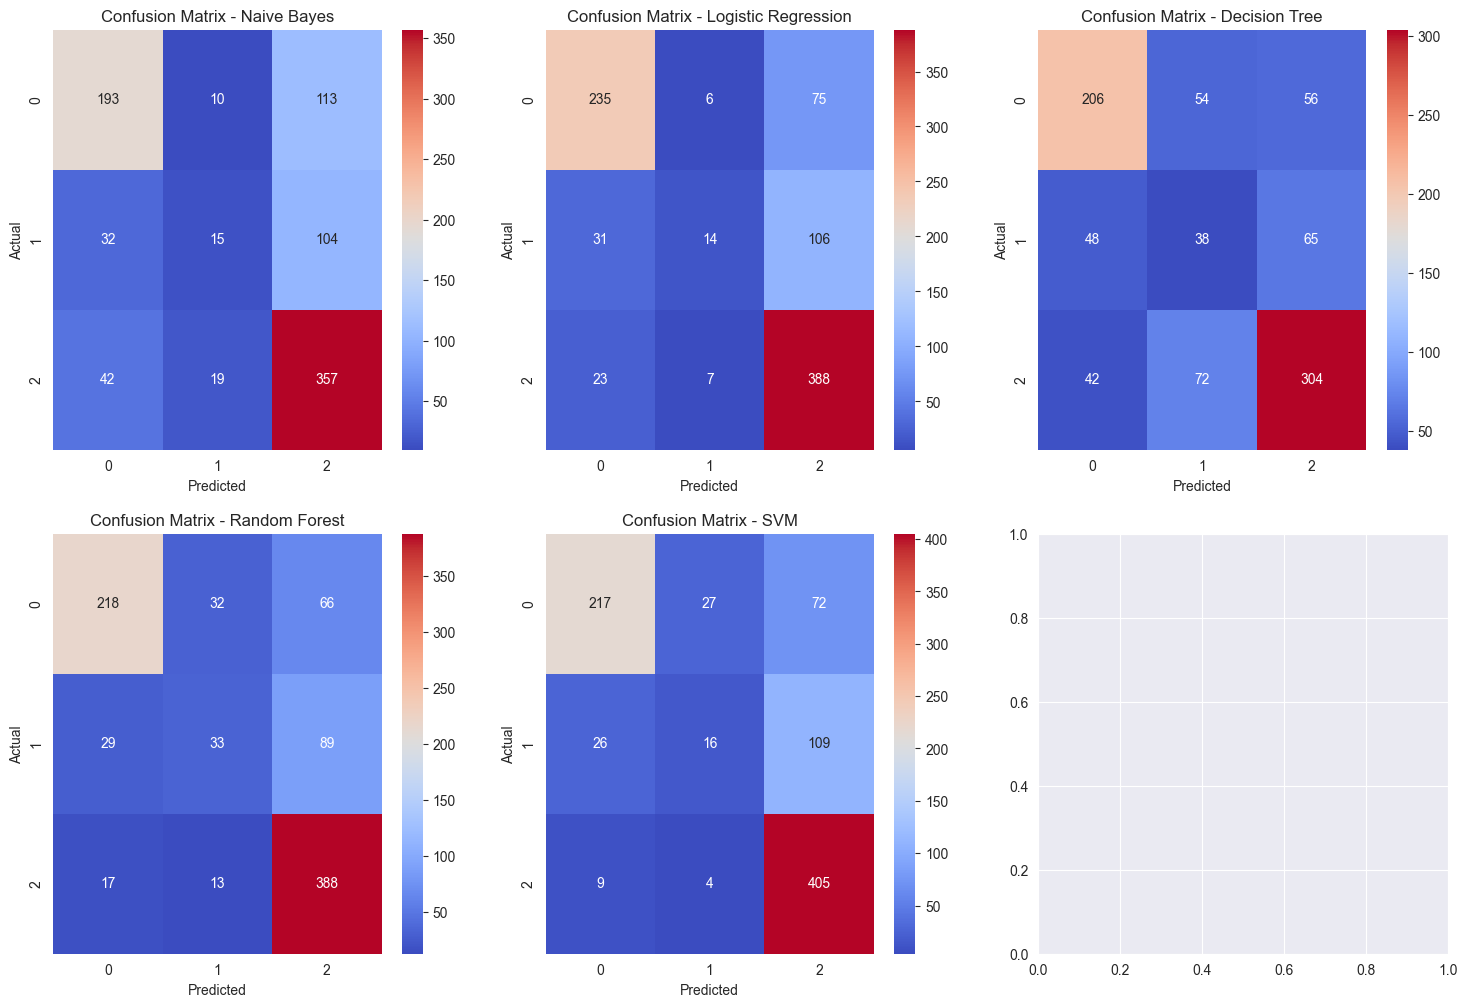

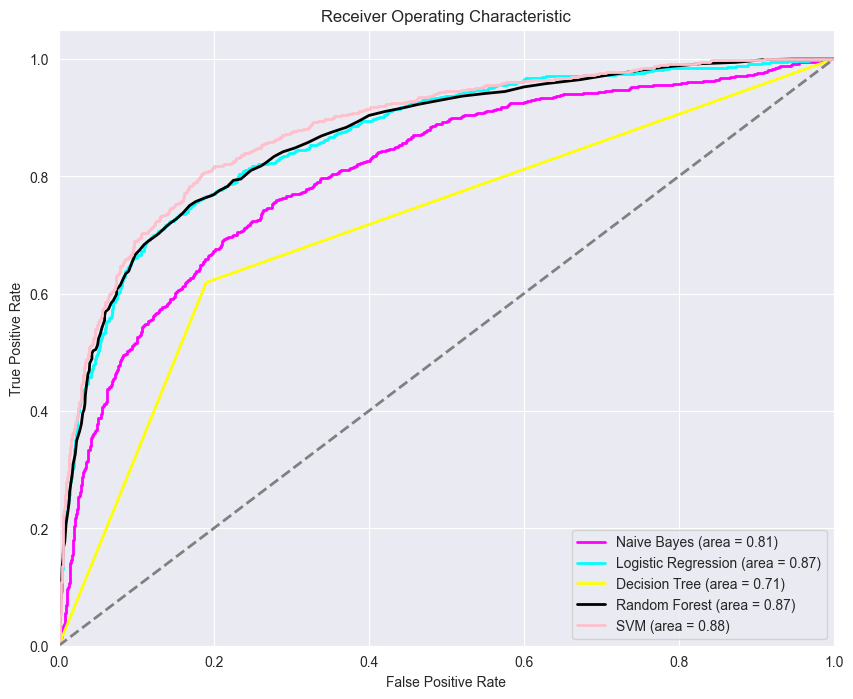

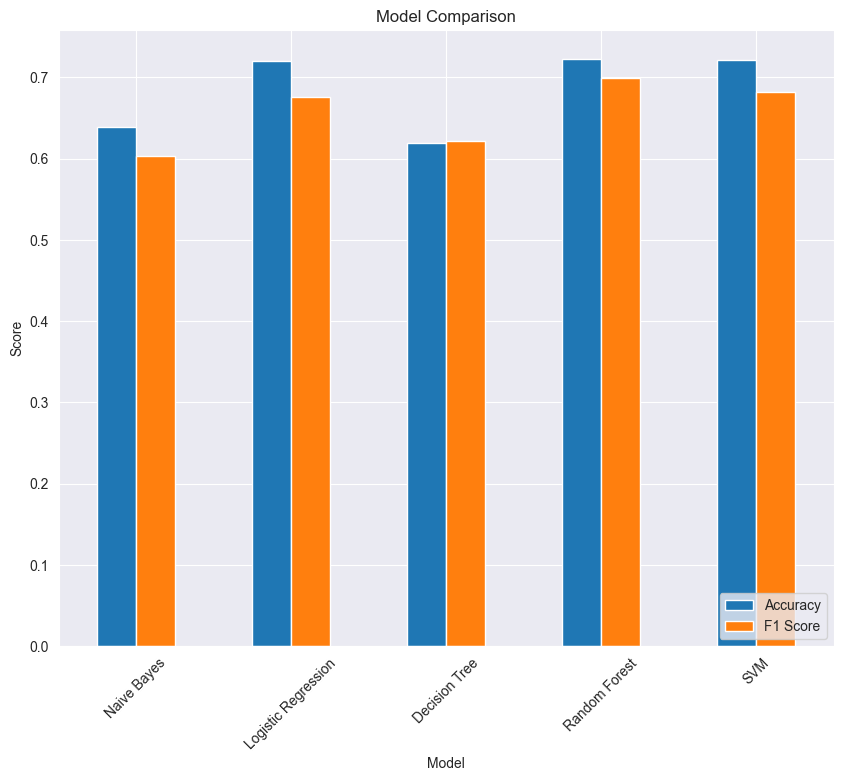

In [73]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='coolwarm')
    axes[i].set_title(f'Confusion Matrix - {name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')


fig, ax = plt.subplots(figsize=(10, 8))

colors = cycle(['magenta', 'cyan', 'yellow', 'black', 'pink'])
for (name, result), color in zip(results.items(), colors):
    fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), result['y_pred_prob'].ravel())
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color=color, lw=2, label=f'{name} (area = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic')
ax.legend(loc="lower right")

metrics_df = pd.DataFrame(results).T[['Accuracy', 'F1 Score']]

fig, ax = plt.subplots(figsize=(10, 8))
metrics_df.plot(kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e'])
ax.set_title('Model Comparison')
ax.set_xlabel('Model')
ax.set_ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.show()